In [71]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics

from rdkit import Chem
from rdkit import DataStructs
from rdkit import rdBase
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve

In [72]:
def PR_curve(y,pred):
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    pred_sort = np.sort(pred)[::-1] 
    index = np.argsort(pred)[::-1]  
    y_sort = y[index]
    print(y_sort)

    Pre = []
    Rec = []
    for i, item in enumerate(pred_sort):
        if i == 0:
            Pre.append(1)
            Rec.append(0)


        else:
            Pre.append(np.sum((y_sort[:i] == 1)) /i)
            Rec.append(np.sum((y_sort[:i] == 1)) / pos)
    print(Pre)
    print(Rec)

    plt.plot(Rec, Pre, 'k',color='skyblue')
    plt.legend(loc='lower right')

    plt.title('Receiver Operating Characteristic')
    #plt.plot([(0, 0), (1, 1)], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 01.01])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

In [73]:
Test_Size = 0.3
times = 20
f_bit = 1024
Mean_acc= []

In [74]:
#df = pd.read_csv('/home/is/zi-yang/Cov/Balanced-SARS-CoV-2_pAC50.csv', index_col=0)
df = pd.read_csv('/home/is/mostatika-a/PBL new/Balanced-SARS-CoV-2_cytopathic_effect_(CPE)-clean.csv', index_col=0)
df['molecules'] = df.SMILES.apply(Chem.MolFromSmiles)
df = df.drop(columns=['SMILES', 'mean_pAC50'])
df

,Class,molecules
SAMPLE_ID,,
NCGC00343768-05,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0100>
NCGC00386831-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f00a0>
NCGC00263232-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0340>
NCGC00246387-06&NCGC00246387-08,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f03a0>
NCGC00263100-02,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0400>
...,...,...
NCGC00378821-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b0487760>
NCGC00182980-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04877c0>
NCGC00480888-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b0487820>


In [75]:
df['ECFP4']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits = f_bit))
df['ECFP6']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits = f_bit))
df['ECFP8']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=4, nBits = f_bit))
df['ECFP10']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=5, nBits = f_bit))
df['ECFP12']=df.molecules.apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=6, nBits = f_bit))
df['RDKFP']=df.molecules.apply(lambda m: AllChem.RDKFingerprint(m, fpSize=512))
df

,Class,molecules,ECFP4,ECFP6,ECFP8,ECFP10,ECFP12,RDKFP
SAMPLE_ID,,,,,,,,
NCGC00343768-05,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0100>,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00386831-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f00a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00263232-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0340>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00246387-06&NCGC00246387-08,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f03a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00263100-02,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0400>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...
NCGC00378821-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b0487760>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00182980-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04877c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
NCGC00480888-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b0487820>,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [76]:
f_names = [x[0] for x in Descriptors._descList]
s = 'Descriptors.'
for i in range(len(f_names)):
    f_names[i] = s + f_names[i]
print('#used features:',len(f_names))

for i in f_names:
    df[i] = df.molecules.apply(lambda m: eval(i)(m))
df = df.dropna()
df

#used features: 200


,Class,molecules,ECFP4,ECFP6,ECFP8,ECFP10,ECFP12,RDKFP,Descriptors.MaxEStateIndex,Descriptors.MinEStateIndex,...,Descriptors.fr_sulfide,Descriptors.fr_sulfonamd,Descriptors.fr_sulfone,Descriptors.fr_term_acetylene,Descriptors.fr_tetrazole,Descriptors.fr_thiazole,Descriptors.fr_thiocyan,Descriptors.fr_thiophene,Descriptors.fr_unbrch_alkane,Descriptors.fr_urea
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
NCGC00343768-05,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0100>,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...",12.325617,-0.426538,...,0,0,0,0,0,0,0,0,0,1
NCGC00386831-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f00a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",12.387263,-1.147456,...,0,0,0,0,0,0,0,0,0,0
NCGC00263232-01,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0340>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13.516034,-0.139098,...,0,0,0,0,0,0,0,0,0,0
NCGC00246387-06&NCGC00246387-08,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f03a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.986619,-0.357879,...,1,0,0,0,0,0,0,0,0,0
NCGC00263100-02,1,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04f0400>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13.983988,-0.882951,...,0,0,0,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCGC00378821-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b0487760>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13.398813,-0.178876,...,0,0,0,1,0,0,0,0,0,0
NCGC00182980-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b04877c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.507249,-0.197997,...,0,0,0,0,0,0,0,0,0,0
NCGC00480888-01,0,<rdkit.Chem.rdchem.Mol object at 0x7fa1b0487820>,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",14.250337,-0.474609,...,1,0,0,0,0,0,0,0,0,0


In [34]:
[x[0] for x in Descriptors._descList]

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

In [77]:
Active = df['Class'].values

ECFP4 = np.array(list(df['ECFP4']))
ECFP6 = np.array(list(df['ECFP6']))
ECFP8 = np.array(list(df['ECFP8']))
ECFP10 = np.array(list(df['ECFP10']))
ECFP12 = np.array(list(df['ECFP12']))
RDKFP = np.array(list(df['RDKFP']))

ECFP4_6 = np.concatenate((ECFP4, ECFP6), axis=1)
ECFP4_8 = np.concatenate((ECFP4, ECFP6, ECFP8), axis=1)
ECFP4_10 = np.concatenate((ECFP4, ECFP6, ECFP8, ECFP10), axis=1)
ECFP4_12 = np.concatenate((ECFP4, ECFP6, ECFP8, ECFP10, ECFP12), axis=1)
ECFP4_12_RDKFP = np.concatenate((ECFP4, ECFP6, ECFP8, ECFP10, ECFP12, RDKFP), axis=1)

features = np.array(df.iloc[:,8:])
ECFP4_6_f = np.concatenate((ECFP4, ECFP6, features), axis=1)

Mean_Train_accuracy_score: 0.9971488178025035
Mean_Test_accuracy_score: 0.8224919093851133
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       144
           1       0.88      0.80      0.84       165

    accuracy                           0.83       309
   macro avg       0.84      0.84      0.83       309
weighted avg       0.84      0.83      0.84       309



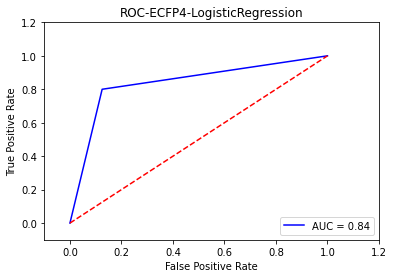

In [79]:
#Test-ECFP4
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()
        

   

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7893203883495146
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       162
           1       0.76      0.78      0.77       147

    accuracy                           0.78       309
   macro avg       0.78      0.78      0.78       309
weighted avg       0.78      0.78      0.78       309



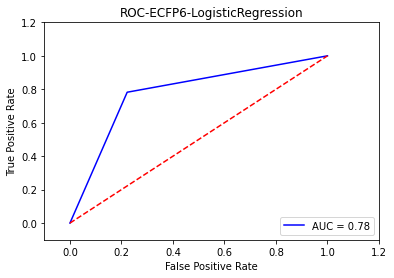

In [80]:
#Test-ECFP6
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP6, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP6-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7802588996763754
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       149
           1       0.81      0.81      0.81       160

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



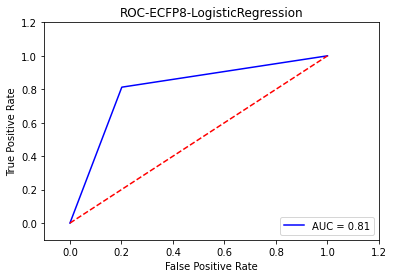

In [83]:
#Test-ECFP8
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP8, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP8-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7744336569579288
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       144
           1       0.85      0.75      0.79       165

    accuracy                           0.79       309
   macro avg       0.80      0.80      0.79       309
weighted avg       0.80      0.79      0.79       309



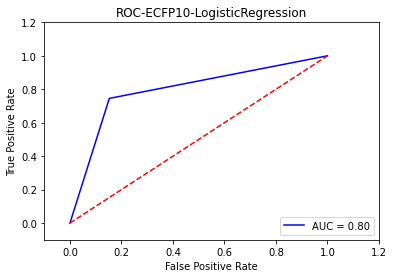

In [49]:
#Test-ECFP10
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP10, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP10-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7622977346278317
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       151
           1       0.83      0.74      0.78       158

    accuracy                           0.79       309
   macro avg       0.79      0.79      0.79       309
weighted avg       0.79      0.79      0.79       309



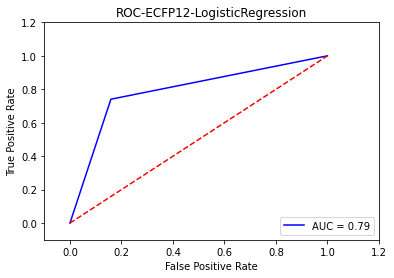

In [50]:
#Test-ECFP12
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP12, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP12-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8144012944983818
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       141
           1       0.83      0.80      0.82       168

    accuracy                           0.81       309
   macro avg       0.80      0.81      0.80       309
weighted avg       0.81      0.81      0.81       309



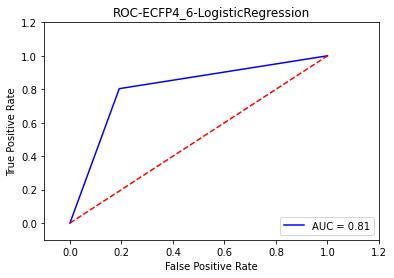

In [51]:
#Test-ECFP4_6
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_6, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_6-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1
 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 0 0 1 0 0]
[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.9444444444444444, 0.9473684210526315, 0.95, 0.9523809523809523, 0.9545454545454546, 0.9565217391304348, 0.9583333333333334, 0.96, 0.9615384615384616, 0.9629629629629629, 0.9

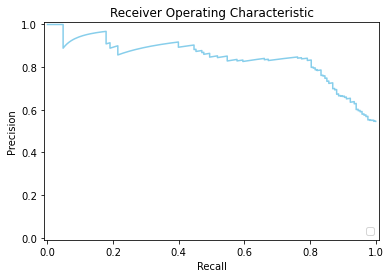

In [52]:
PR_curve(y_test, y_predicted)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.8111650485436893
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       162
           1       0.80      0.81      0.80       147

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



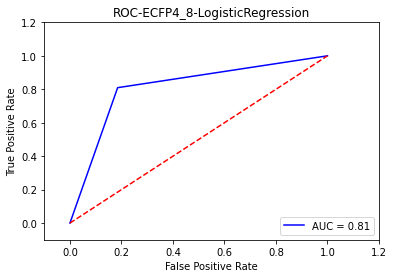

In [53]:
#Test-ECFP4_8
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_8, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_8-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1
 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 0 0 1 0]
[1, 1.0, 1.0, 1.0, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8421052631578947, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.88

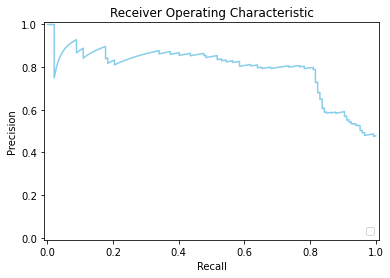

In [54]:
PR_curve(y_test, y_predicted)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7993527508090614
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       157
           1       0.79      0.82      0.81       152

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



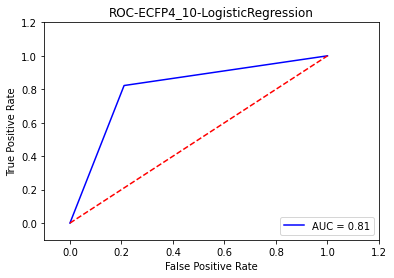

In [55]:
#Test-ECFP4_10
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_10, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_10-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0]
[1, 0.0, 0.5, 0.6666666666666666, 0.75, 0.6, 0.6666666666666666, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7142857142857143, 0.7333333333333333, 0.75, 0.7647058823529411, 0.7222222222222222, 0.7368421052631579, 0.7, 0.6666666666666666, 0.6818181818181818, 0.6956521739130435, 0.7083333333333334, 0.68, 0.69230769230

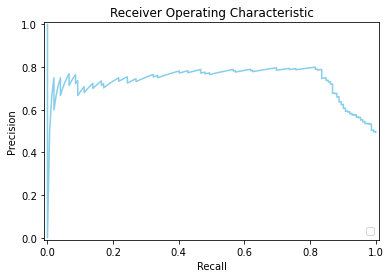

In [56]:
PR_curve(y_test, y_predicted)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean_Train_accuracy_score: 1.0
Mean_Test_accuracy_score: 0.7864077669902912
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       151
           1       0.81      0.77      0.79       158

    accuracy                           0.79       309
   macro avg       0.79      0.79      0.79       309
weighted avg       0.79      0.79      0.79       309



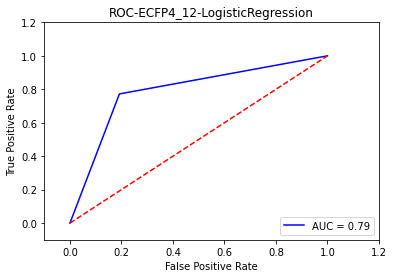

In [84]:
#Test-ECFP4_12
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_12, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_12-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.85, 0.8571428571428571, 0.8181818181818182, 0.8260869565217391, 0.8333333333333334, 0.84, 0.8461538461538461, 0.8518518518518519, 0.8571428571428571, 0.862068965517

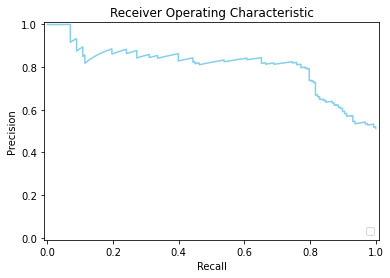

In [85]:
PR_curve(y_test, y_predicted)

Mean_Train_accuracy_score: 0.4985396383866481
Mean_Test_accuracy_score: 0.5033980582524272
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       159
           1       0.00      0.00      0.00       150

    accuracy                           0.51       309
   macro avg       0.26      0.50      0.34       309
weighted avg       0.26      0.51      0.35       309



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

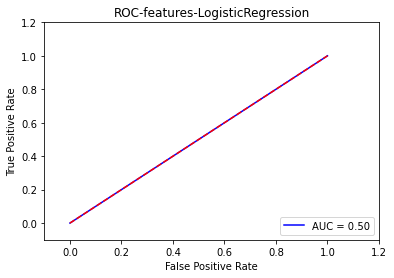

In [86]:
#Test-features
Train_accuracy_score = []
Test_accuracy_score = []

Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(features, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-features-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

 1) Descriptors.MinEStateIndex     0.038394
 2) Descriptors.MaxAbsEStateIndex  0.030100
 3) Descriptors.MinAbsEStateIndex  0.025991
 4) Descriptors.qed                0.023224
 5) Descriptors.MolWt              0.009910
 6) Descriptors.HeavyAtomMolWt     0.008947
 7) Descriptors.ExactMolWt         0.008005
 8) Descriptors.NumValenceElectrons 0.007660
 9) Descriptors.NumRadicalElectrons 0.006391
10) Descriptors.MaxPartialCharge   0.005752
11) Descriptors.MinPartialCharge   0.005278
12) Descriptors.MaxAbsPartialCharge 0.004915
13) Descriptors.MinAbsPartialCharge 0.004901
14) Descriptors.FpDensityMorgan1   0.004587
15) Descriptors.FpDensityMorgan2   0.004298
16) Descriptors.FpDensityMorgan3   0.004097
17) Descriptors.BalabanJ           0.004032
18) Descriptors.BertzCT            0.003827
19) Descriptors.Chi0               0.003810
20) Descriptors.Chi0n              0.003669
21) Descriptors.Chi0v              0.003379
22) Descriptors.Chi1               0.003194
23) Descriptors.Chi1n       

ValueError: shape mismatch: objects cannot be broadcast to a single shape

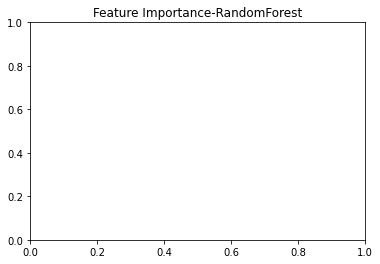

In [61]:
feat_labels = df.iloc[:,8:].columns[1:]
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]-1):
    print ("%2d) %-*s %f" % (f+1,30,feat_labels[f],importances[indices[f]]))
    #print ("%2d) %-*s %f" % (f+1,30,feat_labels[[indices[f]]],importances[indices[f]])) 
plt.title('Feature Importance-RandomForest')
plt.bar(range(X_train.shape[1]),importances[indices],color='lightblue',align='center')
#plt.xticks(range(X_train.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


[1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0
 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1
 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0
 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1
 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0
 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0
 1 1 1 1 0 1 1 0 0 0 0 0 0]
[1, 1.0, 1.0, 0.6666666666666666, 0.75, 0.6, 0.5, 0.5714285714285714, 0.5, 0.5555555555555556, 0.6, 0.5454545454545454, 0.5833333333333334, 0.6153846153846154, 0.6428571428571429, 0.6, 0.5625, 0.5882352941176471, 0.5555555555555556, 0.5789473684210527, 0.6, 0.5714285714285714, 0.5909090909090909, 0.6086956521739131, 0.625, 0.64, 0.6538461538461539, 0.6296296296296297, 0

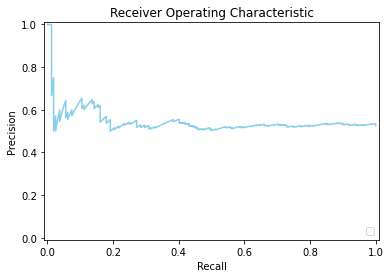

In [62]:
PR_curve(y_test, y_predicted)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Mean_Train_accuracy_score: 0.4987482614742698
Mean_Test_accuracy_score: 0.5029126213592233
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       151
           1       0.00      0.00      0.00       158

    accuracy                           0.49       309
   macro avg       0.24      0.50      0.33       309
weighted avg       0.24      0.49      0.32       309



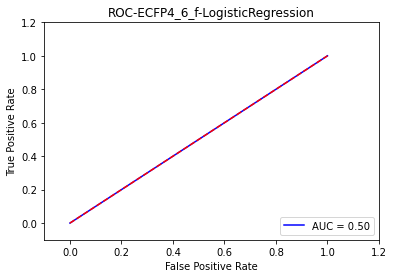

In [63]:
#Test-pca_ECFP4_6_f
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_6_f, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-ECFP4_6_f-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1
 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0
 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1
 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1
 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0
 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 1 1 0 1 0 0 0 1 1 1 1]
[1, 1.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.5, 0.42857142857142855, 0.5, 0.4444444444444444, 0.4, 0.36363636363636365, 0.3333333333333333, 0.38461538461538464, 0.35714285714285715, 0.3333333333333333, 0.375, 0.35294117647058826, 0.3333333333333333, 0.3157894736842105, 0.3, 0.3333333333333333, 0.36363636363636365, 0.391304347826087, 0.375, 0.4, 0.4230769230769231, 0.4

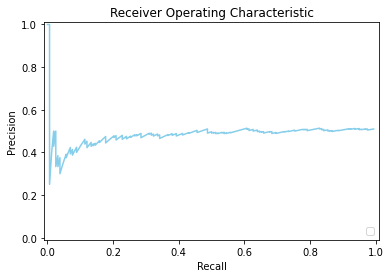

In [64]:
PR_curve(y_test, y_predicted)

In [65]:
estimator = PCA(n_components = 20)
pca_features = estimator.fit_transform(features)
#pca_features = pd.DataFrame(pca_features, columns = [i for i in range(20)])
pca_features

array([[-2.61074735e+26, -3.97098265e+11,  9.17104663e+11, ...,
         3.20248483e+10,  6.38881189e+09, -1.30923882e+09],
       [-2.61074735e+26, -3.02500158e+11,  3.09198374e+11, ...,
         2.27731843e+11,  6.49902027e+11,  6.64418571e+10],
       [-2.61074735e+26,  6.67141667e+11, -4.11879719e+11, ...,
         3.86545640e+11,  7.75345397e+10, -3.02909543e+11],
       ...,
       [-2.61074735e+26,  2.46238533e+11, -1.98294822e+11, ...,
        -7.97634817e+11, -9.37004825e+11, -5.35927012e+11],
       [-2.61074735e+26,  7.00477305e+11, -9.51954861e+10, ...,
         6.68117041e+11, -9.59104198e+11,  9.15985572e+11],
       [-2.61074735e+26, -7.57386833e+11, -5.20355958e+11, ...,
         2.00879297e+11, -1.29196841e+11, -3.26256165e+11]])

Mean_Train_accuracy_score: 0.4993045897079277
Mean_Test_accuracy_score: 0.5032362459546925
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       154
           1       0.00      0.00      0.00       155

    accuracy                           0.50       309
   macro avg       0.25      0.50      0.33       309
weighted avg       0.25      0.50      0.33       309



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

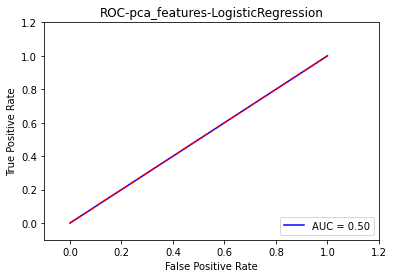

In [66]:
#Test-pca_features
Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(pca_features, Active, test_size= Test_Size)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_ac= model.score(X_train,y_train)
    test_ac= model.score(X_test,y_test)
    
    Train_accuracy_score.append(train_ac)
    Test_accuracy_score.append(test_ac)

y_predicted = model.predict(X_test)
Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, y_predicted, target_names=np.arange(2).astype(str)))    

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)
plt.title('ROC-pca_features-LogisticRegression')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

No handles with labels found to put in legend.


[1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0
 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1
 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0
 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0
 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 1]
[1, 1.0, 0.5, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.375, 0.4444444444444444, 0.5, 0.5454545454545454, 0.5833333333333334, 0.5384615384615384, 0.5, 0.4666666666666667, 0.5, 0.47058823529411764, 0.5, 0.5263157894736842, 0.5, 0.5238095238095238, 0.5, 0.4782608695652174, 0.5, 0.52, 0.5, 0.5185185185185185, 0.5, 0.5172413793103449, 0.5333333

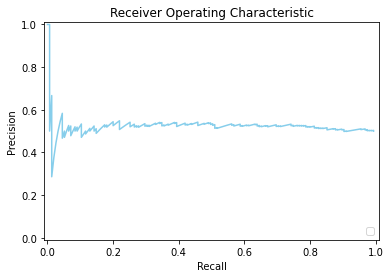

In [67]:
PR_curve(y_test, y_predicted)

 1) 0                              0.038394
 2) 1                              0.030100
 3) 2                              0.025991
 4) 3                              0.023224
 5) 4                              0.009910
 6) 5                              0.008947
 7) 6                              0.008005
 8) 7                              0.007660
 9) 8                              0.006391
10) 9                              0.005752
11) 10                             0.005278
12) 11                             0.004915
13) 12                             0.004901
14) 13                             0.004587
15) 14                             0.004298
16) 15                             0.004097
17) 16                             0.004032
18) 17                             0.003827
19) 18                             0.003810


ValueError: shape mismatch: objects cannot be broadcast to a single shape

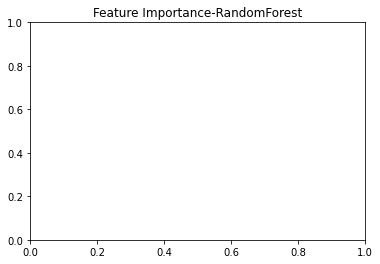

In [68]:
feat_labels = range(20)
importances=rf.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]-1):
    print ("%2d) %-*s %f" % (f+1,30,feat_labels[f],importances[indices[f]]))
    #print ("%2d) %-*s %f" % (f+1,30,feat_labels[[indices[f]]],importances[indices[f]])) 
plt.title('Feature Importance-RandomForest')
plt.bar(range(X_train.shape[1]),importances[indices],color='lightblue',align='center')
#plt.xticks(range(X_train.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

In [26]:
#Test-ECFP4_6_fpca
ECFP4_6_fpca = np.concatenate((ECFP4, ECFP6, pca_features), axis=1)

Train_accuracy_score = []
Test_accuracy_score = []

for i in range(times):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(ECFP4_6_fpca, Active, test_size= Test_Size)

    rf = RandomForestClassifier(max_features='auto')
    rf.fit(X_train, y_train)

    rf_lab = rf.predict(X_train)
    rf_pre = rf.predict(X_test)
    
    Train_accuracy_score.append(accuracy_score(y_train,rf_lab))
    Test_accuracy_score.append(accuracy_score(y_test,rf_pre))

Mean_acc.append(statistics.mean(Test_accuracy_score))
print("Mean_Train_accuracy_score:",statistics.mean(Train_accuracy_score))
print("Mean_Test_accuracy_score:",statistics.mean(Test_accuracy_score))
print(classification_report(y_test, rf_pre, target_names=np.arange(2).astype(str)))

y_pred = rf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('ECFP4_6_fpca')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("ROC.jpg", dpi = 300)
plt.show()

NameError: name 'pca_features' is not defined

No handles with labels found to put in legend.


[1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1, 1.0, 1.0, 0.6666666666666666, 0.5, 0.6, 0.6666666666666666, 0.7142857142857143, 0.75, 0.7777777777777778, 0.8, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85, 0.8571428571428571, 0.8636363636363636, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8888888888888888,

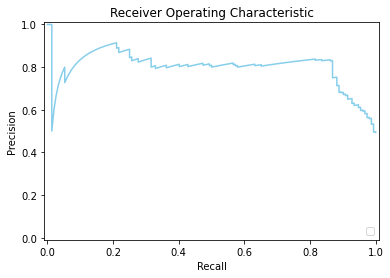

In [27]:
PR_curve(y_test, y_pred)

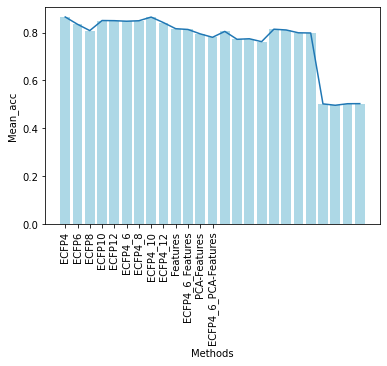

In [69]:
Methods = ['ECFP4','ECFP6','ECFP8','ECFP10','ECFP12','ECFP4_6','ECFP4_8','ECFP4_10','ECFP4_12','Features','ECFP4_6_Features','PCA-Features','ECFP4_6_PCA-Features']
plt.ylabel('Mean_acc')
plt.xlabel('Methods')
plt.plot(Mean_acc)
plt.bar(range(len(Mean_acc)),Mean_acc,color='lightblue',align='center')
plt.xticks(range(13),Methods,rotation=90)
plt.show()
#print(Mean_acc)